## Install and import libraries

In [1]:
! pip install -q qiskit
! pip install -q qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 38.3 MB/s eta 0:00:00


In [59]:
from qiskit import QuantumCircuit, ClassicalRegister, transpile #, execute
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, circuit, array_to_latex
from qiskit.circuit.library import MCMTGate, ZGate
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import numpy as np

### functions

In [62]:
def measure_report(qc: QuantumCircuit, shots: int):
  '''
  Measure a quantum circuit and print the results.
  Args:
    qc: QuantumCircuit
    shots: int
  Returns:
    counts: dict
  '''
  simulator = Aer.get_backend('qasm_simulator')

  qc_t = transpile(qc, simulator)
  job = simulator.run(qc_t, shots=shots)
  counts = job.result().get_counts()
  print(f'total counts: {counts}')
  plot_histogram(counts)

  return counts

def entangle(n: int, basis_state: list[int]) -> (QuantumCircuit) :
  '''
    entangle n qubits in a given basis state
  Args:
    n: int
    basis_state: list[int]
  Returns:
    QuantumCircuit
    img: circuit diagram
  '''
  qc = QuantumCircuit(n,n)  # two qubits, 2 bits

  for i,flip_flag in enumerate(basis_state):
    if flip_flag == 1:
      qc.x(i)

  qc.h(0)                   # hadamard to first qubit to create superposition

  for i in range(n-1):
    qc.cx(i,i+1)                # CNOT (controlled X) between each subsequent pair

  s = Statevector.from_instruction(qc)
  img = s.draw('latex', prefix=r'\ket{\psi_{entangled}} = ')
  display(img)

  for i in range(n):
    qc.measure(i,i)

  img = qc.draw()

  return qc, img

def teleport():
  '''
  teleport a qubit from source to target
  '''
  three_states = ['000', '001', '010', '011', '100', '101', '110', '111']
  two_states = ['00', '01', '10', '11']

  # create a quantum circuit with 3 qubits and 3 classical bits
  qc = QuantumCircuit(3,3)

  # put source into a ramdom state:
  qc.rx(np.pi/2, 0)
  qc.ry(2*np.pi/3, 0)
  # qc.rz(3*np.pi/4, 0)

  print('Initial State: source qubit in random state and messenger and target qubits in 0 state.')
  s = Statevector.from_instruction(qc)
  img = s.draw('latex', prefix=r'\ket{\psi_0} = ')
  display(img)

  ## make state to display source qubit
  print('source qubit:')
  qc_test = QuantumCircuit(1)
  s_test = [val for val in s if val != 0.0]
  qc_test.prepare_state(s_test, [0])

  s_test = Statevector.from_instruction(qc_test)

  img = s_test.draw('latex', prefix=r'\ket{\psi_0^{q=0}} = ')
  display(img)

  print('Probabilities for intial state:')
  for state, prob_amp in zip(three_states, s):
    prob = abs(prob_amp)**2
    print(f'state {state}: {(prob*100):.2f}%')
  print('')

  print('Apply Hadamard gate to messenger qubit; entangle messenger and target')
  qc.h(1)
  qc.cx(1,2)

  qc.cx(0,1)
  qc.h(0)

  print('Teleported state:')
  s = Statevector.from_instruction(qc)
  img = s.draw('latex',  prefix=r'\ket{\psi_{tele}} = ')
  display(img)

  print('Probabilities for each teleported state:')
  for state, prob_amp in zip(three_states, s):
    prob = abs(prob_amp)**2
    print(f'state {state}: {(prob*100):.2f}%')

  #choose a random integer for measurement
  state_choice = np.random.randint(0,4)
  measured_state = two_states[state_choice]
  print(f'Source and messenger measured state: {measured_state}')

  # delete any basis state that does not include the chosen measurement
  new_s = []
  for state, coeffs in zip(three_states,s):
    if state[2:0:-1] != measured_state:
      new_s.append(0.0)
    else:
      new_s.append(coeffs)

  ## normalize the new_s vector for the measured state
  new_s = new_s/np.linalg.norm(new_s)

  s = Statevector(new_s)
  img = s.draw('latex',  prefix=r'\ket{\psi_{measured}} = ')
  display(img)

  qc = QuantumCircuit(3)
  qc.prepare_state(s, [0,1,2])

  ''' Code to verify state was transferred correctly
  print('transfered state:')
  s = Statevector.from_instruction(qc)
  img = s.draw('latex',  prefix=r'\ket{\psi_{measured}} = ')
  display(img)
  '''
  print('Apply transformations based on source and messenger measurements:')

  if measured_state == '00':
    print('applying I')
    qc.id(2)
  elif measured_state == '01':
    print('applying X')
    qc.x(2)
  elif measured_state == '10':
    print('applying Z')
    qc.z(2)
  elif measured_state == '11':
    print('applying XZ')
    qc.z(2)
    qc.x(2)

  print('Final state:')
  for state, prob_amp in zip(three_states, s):
    prob = abs(prob_amp)**2
    print(f'state {state}: {(prob*100):.2f}%')

  s = Statevector.from_instruction(qc)
  img = s.draw('latex', prefix=r'\ket{\psi_f} = ')
  display(img)

  ## make state to display target qubit
  print('Target qubit final state:')
  final_target = []
  for coeff, state in zip(s, three_states):
    if abs(coeff) > 0.0000001:
      final_target.append(coeff)
  final_s = Statevector(final_target)
  img = final_s.draw('latex',  prefix=r'\ket{\psi_{final, target}} = ')
  display(img)

class grovers():
  '''
  '''
  def __init__(self, target_state, num_qubits):
    self.num_qubits = num_qubits
    self.target_state = target_state  # should be supplied in reverse order
    self.cont_z = MCMTGate(ZGate(),self.num_qubits-1, 1)
    self.num_iterations = int(np.pi/4*np.sqrt(2**self.num_qubits))

  def oracle(self):
    '''
    '''
    qc_oracle = QuantumCircuit(self.num_qubits)
    for i, char in enumerate(reversed(self.target_state)):
      if char == '0':
        qc_oracle.x(i)

    # s = Statevector.from_instruction(qc_oracle)
    # img = s.draw('latex',  prefix=r'\ket{\psi_{initial}} = ')
    # display(img)

    ## define control qubits
    qc_oracle.append(self.cont_z, range(self.num_qubits))

    for i, char in enumerate(reversed(self.target_state)):
      if char == '0':
        qc_oracle.x(i)

    # s = Statevector.from_instruction(qc_oracle)
    # img = s.draw('latex',  prefix=r'\ket{\psi_{oracle}} = ')
    # display(img)

    return qc_oracle.to_gate(label='oracle')

  def diffusion(self):
    '''
    '''
    qc_diffusion = QuantumCircuit(self.num_qubits)

    for i in range(self.num_qubits):
      qc_diffusion.h(i)

    for i in range(self.num_qubits):
      qc_diffusion.x(i)

    qc_diffusion.append(self.cont_z, range(self.num_qubits))

    for i in range(self.num_qubits):
      qc_diffusion.x(i)

    for i in range(self.num_qubits):
      qc_diffusion.h(i)


    return qc_diffusion.to_gate(label='diffusion')

  def grover(self):
    '''
    '''
    three_states = ['000', '001', '010', '011', '100', '101', '110', '111']

    qc_grover = QuantumCircuit(self.num_qubits, self.num_qubits)

    for i in range(self.num_qubits):
      qc_grover.h(i)

    for i in range(self.num_iterations):
      qc_grover.append(self.oracle(), range(self.num_qubits))
      qc_grover.append(self.diffusion(), range(self.num_qubits))

    print('total state:')
    s = Statevector.from_instruction(qc_grover)
    img = s.draw('latex',  prefix=r'\ket{\psi_{grover}} = ')
    display(img)

    largest_state = np.argmax(s)
    chosen_state = three_states[largest_state]
    print(f'target state: {self.target_state}')
    print(f'likely state: {chosen_state}')

    qc_grover.measure(range(self.num_qubits), range(self.num_qubits))
    counts = measure_report(qc_grover, 1000)

    return counts


<>:132: SyntaxWarning: invalid escape sequence '\k'
<>:132: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipython-input-3011075077.py:132: SyntaxWarning: invalid escape sequence '\k'
  img = s.draw('latex',  prefix=r'\ket{\psi_{measured}} = ')


### One qubit, apply Hadamard gate and measure

In [65]:
quantum_circuit = QuantumCircuit(1,1) # one qubit and one bit
quantum_circuit.h(0)

s = Statevector.from_instruction(quantum_circuit)
s.draw('latex', prefix=r'\ket{\psi} = ')


<IPython.core.display.Latex object>

In [66]:
quantum_circuit.draw()

┌───┐
  q: ┤ H ├
     └───┘
c: 1/═════

total counts: {'1': 521, '0': 479}


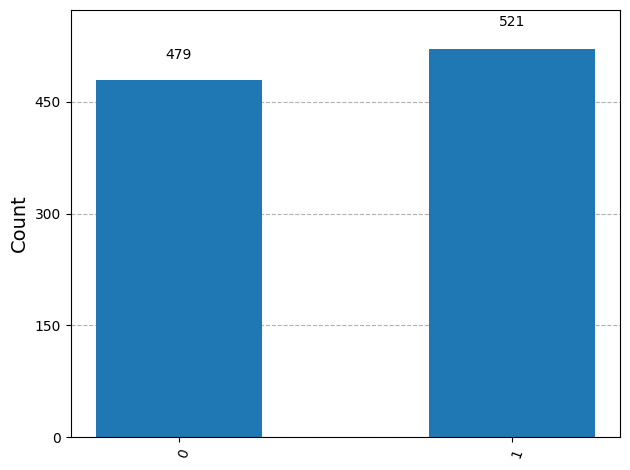

In [67]:
quantum_circuit.measure(0,0)
counts = measure_report(quantum_circuit, 1000)
plot_histogram(counts)

### Entanglement

In [68]:
qc, img = entangle(2, [0,1])

<IPython.core.display.Latex object>

In [69]:
counts = measure_report(qc, 1000)

total counts: {'01': 517, '10': 483}


In [70]:
img

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     ├───┤┌─┴─┐└╥┘┌─┐
q_1: ┤ X ├┤ X ├─╫─┤M├
     └───┘└───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [71]:
qc, img = entangle(2, [0,0])
counts = measure_report(qc, 1000)

<IPython.core.display.Latex object>

total counts: {'00': 500, '11': 500}


In [72]:
img

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [73]:
qc, img = entangle(3, [0,0,0])
counts = measure_report(qc, 1000)

<IPython.core.display.Latex object>

total counts: {'111': 500, '000': 500}


In [74]:
img

┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2

In [75]:
qc, img = entangle(3, [1,1,1])
count = measure_report(qc, 1000)

<IPython.core.display.Latex object>

total counts: {'010': 504, '101': 496}


In [76]:
img

┌───┐┌───┐          ┌─┐      
q_0: ┤ X ├┤ H ├──■───────┤M├──────
     ├───┤└───┘┌─┴─┐     └╥┘┌─┐   
q_1: ┤ X ├─────┤ X ├──■───╫─┤M├───
     ├───┤     └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ┤ X ├──────────┤ X ├─╫──╫─┤M├
     └───┘          └───┘ ║  ║ └╥┘
c: 3/═════════════════════╩══╩══╩═
                          0  1  2

### Teleportation

In [77]:
teleport()

Initial State: source qubit in random state and messenger and target qubits in 0 state.


<IPython.core.display.Latex object>

source qubit:


<IPython.core.display.Latex object>

Probabilities for intial state:
state 000: 50.00%
state 001: 50.00%
state 010: 0.00%
state 011: 0.00%
state 100: 0.00%
state 101: 0.00%
state 110: 0.00%
state 111: 0.00%

Apply Hadamard gate to messenger qubit; entangle messenger and target
Teleported state:


<IPython.core.display.Latex object>

Probabilities for each teleported state:
state 000: 12.50%
state 001: 12.50%
state 010: 12.50%
state 011: 12.50%
state 100: 12.50%
state 101: 12.50%
state 110: 12.50%
state 111: 12.50%
Source and messenger measured state: 00


<IPython.core.display.Latex object>

Apply transformations based on source and messenger measurements:
applying I
Final state:
state 000: 50.00%
state 001: 0.00%
state 010: 0.00%
state 011: 0.00%
state 100: 50.00%
state 101: 0.00%
state 110: 0.00%
state 111: 0.00%


<IPython.core.display.Latex object>

Target qubit final state:


<IPython.core.display.Latex object>

### Grover's search algorithm

total state:


<IPython.core.display.Latex object>

target state: 101
likely state: 101
total counts: {'100': 10, '110': 7, '000': 6, '010': 5, '011': 9, '111': 9, '001': 9, '101': 945}


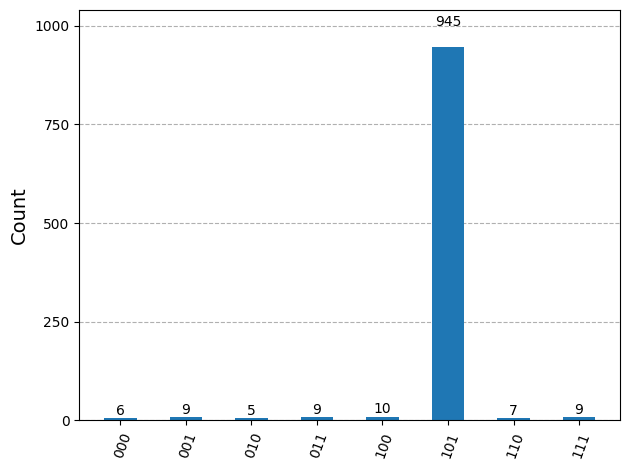

In [64]:
Grover = grovers('101', 3)
counts = Grover.grover()
plot_histogram(counts)